In [2]:
%matplotlib inline

from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE, SelectKBest, chi2, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

# Data Exploration

In [3]:
DATA_DIR = './data/'

In [45]:
train_values = pd.read_csv(DATA_DIR + 'train_values.csv', index_col='building_id')
train_labels = pd.read_csv(DATA_DIR + 'train_labels.csv', index_col='building_id')
test_values = pd.read_csv(DATA_DIR + 'test_values.csv', index_col='building_id')

In [4]:
train_values.dtypes

geo_level_1_id                             int64
geo_level_2_id                             int64
geo_level_3_id                             int64
count_floors_pre_eq                        int64
age                                        int64
area_percentage                            int64
height_percentage                          int64
land_surface_condition                    object
foundation_type                           object
roof_type                                 object
ground_floor_type                         object
other_floor_type                          object
position                                  object
plan_configuration                        object
has_superstructure_adobe_mud               int64
has_superstructure_mud_mortar_stone        int64
has_superstructure_stone_flag              int64
has_superstructure_cement_mortar_stone     int64
has_superstructure_mud_mortar_brick        int64
has_superstructure_cement_mortar_brick     int64
has_superstructure_t

In [24]:
train_dic = {}
for idx, row in train_values.iterrows():
    tupl = (row['geo_level_1_id'], row['geo_level_2_id'], row['geo_level_3_id'])
    if tupl not in train_dic:
        train_dic[tupl] = 0
    train_dic[tupl] += 1

test_dic = {}
for idx, row in test_values.iterrows():
    tupl = (row['geo_level_1_id'], row['geo_level_2_id'], row['geo_level_3_id'])
    if tupl not in test_dic:
        test_dic[tupl] = 0
    test_dic[tupl] += 1

In [48]:
df = pd.concat([train_values,train_labels], axis=1)
categories = df['geo_level_1_id'].unique()
targets = df['damage_grade'].unique()
cat_list = []
for cat in categories:
    aux_dict = {}
    aux_dict['category'] = cat
    aux_df = df[df['geo_level_1_id'] == cat]
    counts = aux_df['damage_grade'].value_counts()
    aux_dict['count'] = sum(counts)
    for t in targets:
        aux_dict['target_' + str(t)] = counts[t] if t in counts.keys() else 0
    cat_list.append(aux_dict)
cat_list = pd.DataFrame(cat_list)
for t in targets:
    cat_list['geo_level_1_id_encoded_target_' + str(t)] = cat_list['target_' + str(t)] / cat_list['count']

In [68]:
from category_encoders import TargetEncoder

target_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
df = pd.concat([train_values, train_labels], axis=1)
df['geo_level_1_id'] = df['geo_level_1_id'].map(str)
df['geo_level_2_id'] = df['geo_level_2_id'].map(str)
df['geo_level_3_id'] = df['geo_level_3_id'].map(str)
targets = df['damage_grade'].unique()
for feature in target_features:
    for t in targets:
        target_aux = df['damage_grade'].apply(lambda x: 1 if x == t else 0)
        encoder = TargetEncoder()
        df[feature+'_encoded_sklearn_target_' + str(t)] = encoder.fit_transform(df[feature], target_aux)

In [70]:
df

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,...,damage_grade,geo_level_1_id_encoded_sklearn_target_3,geo_level_1_id_encoded_sklearn_target_2,geo_level_1_id_encoded_sklearn_target_1,geo_level_2_id_encoded_sklearn_target_3,geo_level_2_id_encoded_sklearn_target_2,geo_level_2_id_encoded_sklearn_target_1,geo_level_3_id_encoded_sklearn_target_3,geo_level_3_id_encoded_sklearn_target_2,geo_level_3_id_encoded_sklearn_target_1
building_id,,,,,,,,,,,,,,,,,,,,,
802906,6,487,12198,2,30,6,5,t,r,n,...,3,0.248185,0.665354,0.086461,0.744444,0.251852,3.703704e-03,0.760117,0.224991,0.014892
28830,8,900,2812,2,10,8,7,o,r,n,...,2,0.519549,0.446174,0.034277,0.497487,0.492462,1.005025e-02,0.250533,0.666667,0.082800
94947,21,363,8973,2,10,5,5,t,r,n,...,3,0.584996,0.393378,0.021627,0.601136,0.316477,8.238636e-02,0.610292,0.360296,0.029412
590882,22,418,10694,2,10,6,5,t,r,n,...,2,0.130678,0.739603,0.129718,0.126829,0.853659,1.951220e-02,0.180391,0.771330,0.048279
201944,11,131,1488,3,30,8,9,t,r,n,...,3,0.384672,0.568370,0.046959,0.378613,0.591522,2.986513e-02,0.377048,0.614752,0.008200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688636,25,1335,1621,1,55,6,3,n,r,n,...,2,0.137269,0.779516,0.083215,0.103464,0.724127,1.724086e-01,0.241399,0.696355,0.062246
669485,17,715,2060,2,0,6,5,t,r,n,...,3,0.807546,0.179388,0.013066,0.934866,0.061303,3.831418e-03,0.945957,0.049015,0.005028
602512,17,51,8163,3,55,6,7,t,r,q,...,3,0.807546,0.179388,0.013066,0.918919,0.057057,2.402402e-02,0.625518,0.306090,0.068392


In [5]:
train_values.describe()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
count,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,...,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000
mean,13.900353,701.074685,6257.876148,2.129723,26.535029,8.018051,5.434365,0.088645,0.761935,0.034332,...,0.064378,0.033626,0.008101,0.000940,0.000361,0.001071,0.000188,0.000146,0.000088,0.005119
std,8.033617,412.710734,3646.369645,0.727665,73.565937,4.392231,1.918418,0.284231,0.425900,0.182081,...,0.245426,0.180265,0.089638,0.030647,0.018989,0.032703,0.013711,0.012075,0.009394,0.071364
min,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.000000,350.000000,3073.000000,2.000000,10.000000,5.000000,4.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,12.000000,702.000000,6270.000000,2.000000,15.000000,7.000000,5.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,21.000000,1050.000000,9412.000000,2.000000,30.000000,9.000000,6.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,30.000000,1427.000000,12567.000000,9.000000,995.000000,100.000000,32.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<Axes: title={'center': 'Number of Buildings with Each Damage Grade'}>

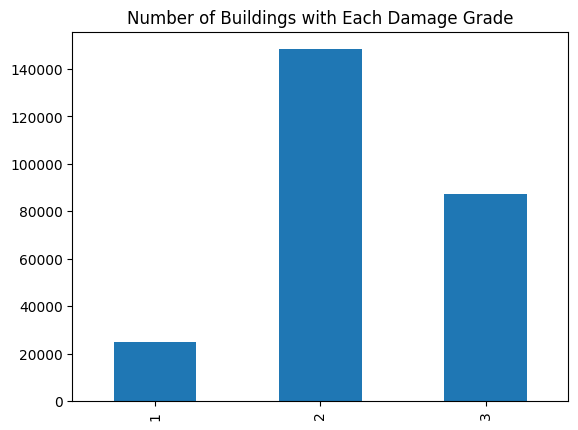

In [6]:
(train_labels.damage_grade
             .value_counts()
             .sort_index()
             .plot.bar(title="Number of Buildings with Each Damage Grade"))

In [7]:
print(train_values.isnull().sum())

geo_level_1_id                            0
geo_level_2_id                            0
geo_level_3_id                            0
count_floors_pre_eq                       0
age                                       0
area_percentage                           0
height_percentage                         0
land_surface_condition                    0
foundation_type                           0
roof_type                                 0
ground_floor_type                         0
other_floor_type                          0
position                                  0
plan_configuration                        0
has_superstructure_adobe_mud              0
has_superstructure_mud_mortar_stone       0
has_superstructure_stone_flag             0
has_superstructure_cement_mortar_stone    0
has_superstructure_mud_mortar_brick       0
has_superstructure_cement_mortar_brick    0
has_superstructure_timber                 0
has_superstructure_bamboo                 0
has_superstructure_rc_non_engine

In [8]:
numerical = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'count_floors_pre_eq', 'age', 'area_percentage', 
             'height_percentage', 'count_families']
categorical = list(set(train_values.columns)-set(numerical))

In [9]:
#for col in train_values.columns:
#    print(train_values[col].value_counts())

In [10]:
categorical_data = train_values[categorical]
oe = OrdinalEncoder()
oe.fit(categorical_data)
categorical_data_enc = oe.transform(categorical_data)
fs = SelectKBest(score_func=chi2, k='all')
X_new = fs.fit_transform(categorical_data_enc, train_labels)

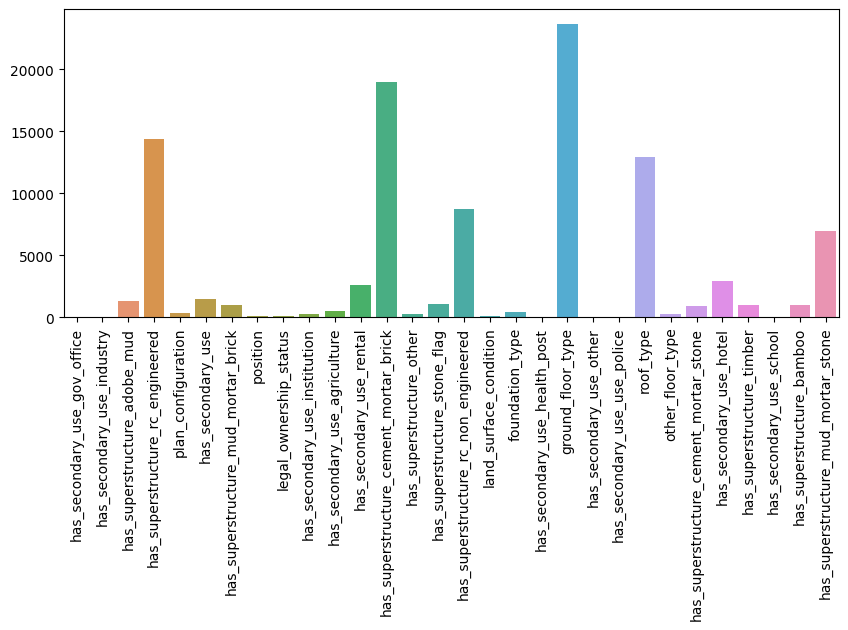

In [11]:
names = []
values = []
for i in range(len(fs.scores_)):
    names.append(categorical_data.columns[i])
    values.append(fs.scores_[i])
chi_list = zip(names, values)

# plot the scores
plt.figure(figsize=(10,4))
sns.barplot(x=names, y=values)
plt.xticks(rotation = 90)
plt.show()

In [12]:
fs = SelectKBest(score_func=chi2, k=6)
X_new = fs.fit_transform(categorical_data_enc, train_labels)
fs.get_feature_names_out()

array(['x3', 'x12', 'x15', 'x19', 'x22', 'x29'], dtype=object)

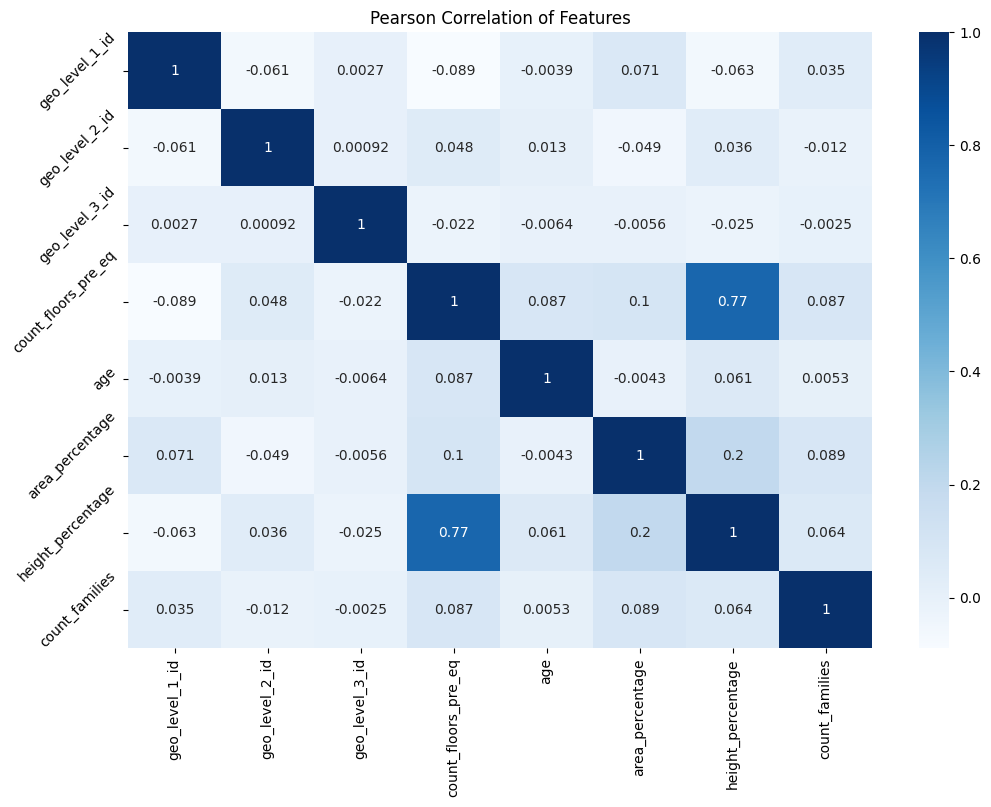

In [13]:
numerical_data = train_values[numerical]
corr = numerical_data.corr()

f, ax = plt.subplots(figsize=(12, 8))

sns.heatmap(corr, cmap="Blues", annot=True, square=False, ax=ax)
plt.title('Pearson Correlation of Features')
plt.yticks(rotation=45);

In [14]:
scaler = StandardScaler().fit(numerical_data)
numerical_data_scaled = scaler.transform(numerical_data)

# User SelectKBest to select top 20 features based on f-test
fs = SelectKBest(f_classif, k='all')

# Fit to scaled data, then transform it
X_new = fs.fit_transform(numerical_data_scaled, train_labels)

/Users/dongwonj/miniforge3/envs/ml/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


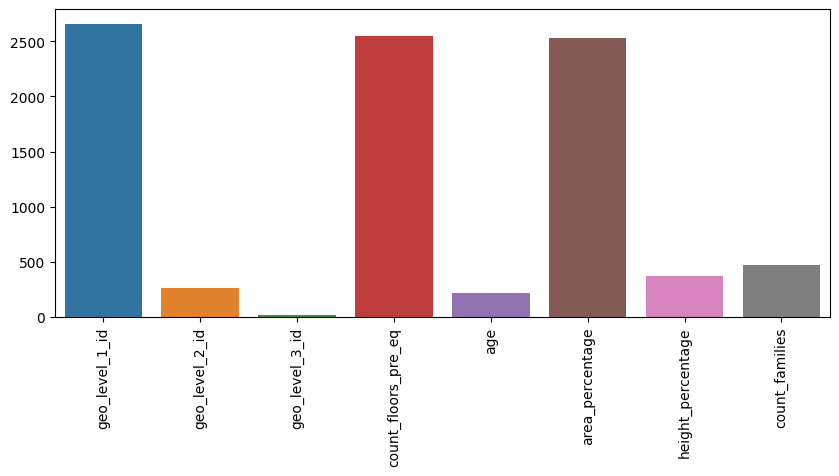

In [15]:
names = []
values = []
for i in range(len(fs.scores_)):
    names.append(numerical_data.columns[i])
    values.append(fs.scores_[i])
chi_list = zip(names, values)

# plot the scores
plt.figure(figsize=(10,4))
sns.barplot(x=names, y=values)
plt.xticks(rotation = 90)
plt.show()

# Model Training

In [1]:

numerical_columns = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'count_floors_pre_eq', 'age', 'area_percentage', 
             'height_percentage', 'count_families']
categorical_columns = list(set(train_values.columns)-set(numerical_columns))
#numerical_columns = ['geo_level_1_id','count_floors_pre_eq','age','area_percentage','height_percentage','count_families']
#categorical_columns = ['ground_floor_type','roof_type','has_superstructure_rc_non_engineered','has_secondary_use_hotel',
#                 'has_secondary_use_rental','has_superstructure_rc_engineered','has_superstructure_cement_mortar_brick',
#                 'has_superstructure_mud_mortar_stone']

NameError: name 'train_values' is not defined

### Data Preprocessing

In [33]:
encoder = OneHotEncoder(sparse_output=False)
categorical_values_encoded = pd.DataFrame(encoder.fit_transform(train_values[categorical_columns]), 
                                          columns=encoder.get_feature_names_out(categorical_columns))
test_categorical_values_encoded = pd.DataFrame(encoder.fit_transform(test_values[categorical_columns]), 
                                          columns=encoder.get_feature_names_out(categorical_columns))

scaler = MinMaxScaler()
numerical_values_scaled = pd.DataFrame(scaler.fit_transform(train_values[numerical_columns]),
                                      columns = numerical_columns)
test_numerical_values_scaled = pd.DataFrame(scaler.fit_transform(test_values[numerical_columns]),
                                      columns = numerical_columns)

train_values_transformed = pd.concat([numerical_values_scaled,categorical_values_encoded], axis=1)
test_values_transformed = pd.concat([test_numerical_values_scaled,test_categorical_values_encoded], axis=1)

### Feature Selection using Random Forest Classifier

In [34]:
model = RandomForestClassifier(random_state=42, class_weight='balanced')
rfe = RFE(model, n_features_to_select=50)
rfe.fit(processed_train_value, train_labels.ravel())
selected_features = processed_train_value.columns[rfe.get_support()]

### Training with Hyperparameter Tuning 

In [35]:
X_train, X_test, y_train, y_test = train_test_split( 
                    processed_train_value[selected_features],train_labels,test_size = 0.20, random_state = 42)
param_grid = {'n_estimators': [50, 100],
          'min_samples_leaf': [1, 5]}
gs = GridSearchCV(model, param_grid, scoring='f1_micro', cv=5)
gs.fit(X_train, y_train.values.ravel())
print('Best params:', gs.best_params_)
predictions = gs.predict(X_test)
best_score = f1_score(y_test, predictions, average='micro')
print('Best fl_micro score:', best_score)

Best params: {'min_samples_leaf': 1, 'n_estimators': 100}


0.71272615644366

### Test

In [36]:
test_model = RandomForestClassifier(random_state=42, n_estimators=100, min_samples_leaf=1, class_weight='balanced')
test_model.fit(train_values_transformed[selected_features], train_labels.values.ravel())
predictions = test_model.predict(test_values_transformed[feature_names])
submission = pd.DataFrame(data=predictions,
                             columns=submission_format.columns,
                             index=submission_format.index)

In [37]:
submission

,damage_grade
building_id,
300051,3
99355,2
890251,2
745817,1
421793,3
...,...
310028,2
663567,2
1049160,2


In [38]:
submission.to_csv(save_path + 'submission.csv')